# 3-9. 프로젝트 : 주식 예측에 도전해 보자
##### !. VScode 플랫폼을 사용하여 가상환경 Python 3.9.7버전에서 작성되었습니다.


---

### STEP 0: 주요라이브러리 import

In [1]:
import pandas # version 1.4.2
import sklearn # version 1.0.2 
import statsmodels # version 0.13.2

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.2
1.0.2
0.13.2


In [2]:
# data source: https://finance.yahoo.com/
# data name: '005930.KS.csv' samsung inc

### STEP 1: 시계열 데이터 준비

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/Desktop/CODE/LMS/[E-03]ARIMA/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-05-06    82300.0
2021-05-07    81900.0
2021-05-10    83200.0
2021-05-11    81200.0
2021-05-12    80000.0
Name: Close, dtype: float64

### STEP 2: 각종 전처리 수행  
*결측치 처리  
*로그 변환  

In [4]:
# 결측치 처리
ts.isnull().sum()
#ts = ts.interpolate(method='time')
#ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

0

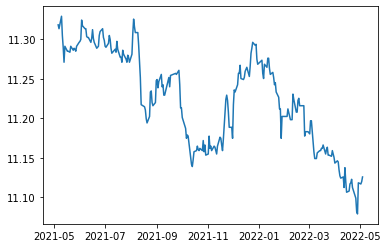

In [5]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3: 시계열 안정성 분석  
*정성적 그래프 분석  
*정량적 Augmented Dicky-Fuller Test  
*시계열 분해(Time Series Decomposition)  
*Residual 안정성 확인  

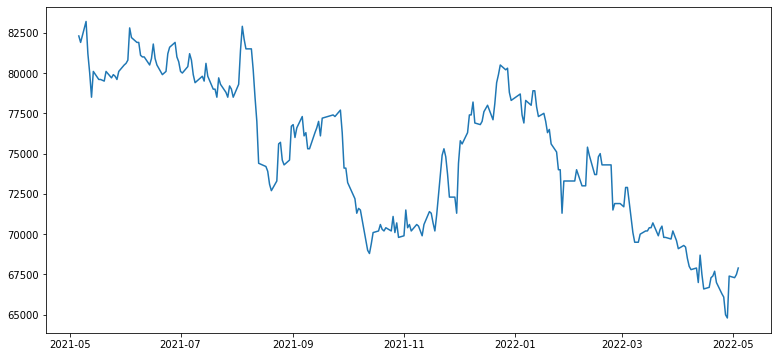

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정.

# 시계열(time series) 데이터를 차트로 그림. 특별히 더 가공하지 않아도 잘 그려짐.
plt.plot(ts)

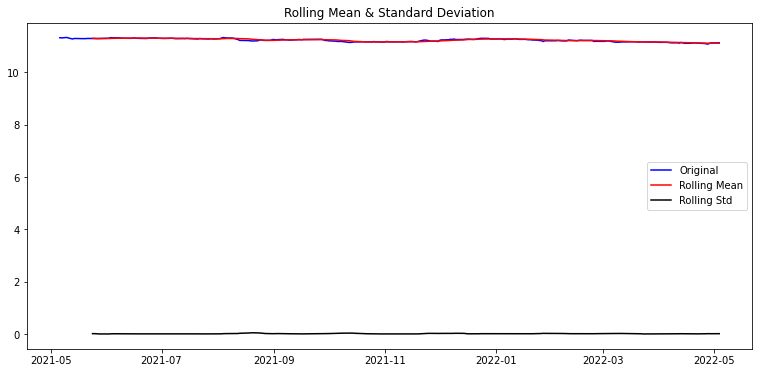

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [8]:
# adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    #정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.541278
p-value                          0.513002
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


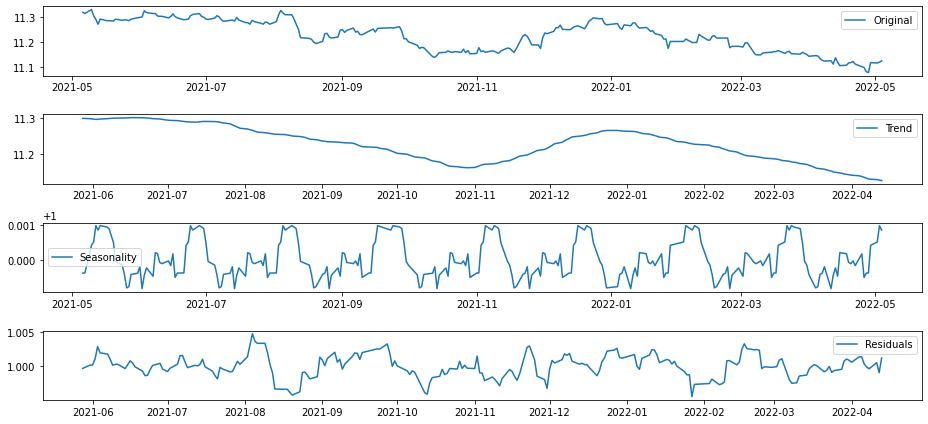

In [9]:

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [10]:
# Residual로 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.438379
p-value                          0.000003
#Lags Used                       1.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


### STEP 4: 학습, 테스트 데이터셋 생성

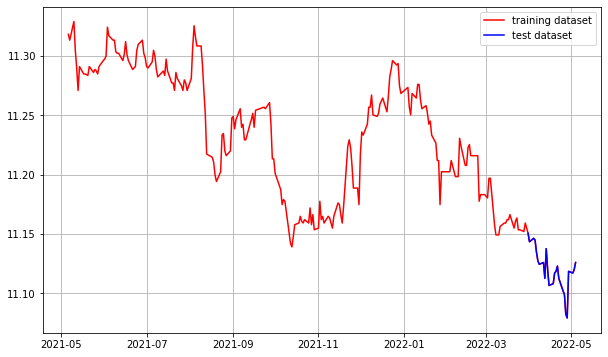

In [11]:
#학습데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [12]:
#데이터셋 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-05-06    11.318126
2021-05-07    11.313254
Name: Close, dtype: float64
(221,)
(25,)


### STEP 5: 적정 ARIMA 모수 찾기  
*ACF,PACF 그려보기 -> p,q 구하기  
*차분 안정성 확인 -> d 구하기  

/Users/hpcd/Desktop/Code/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


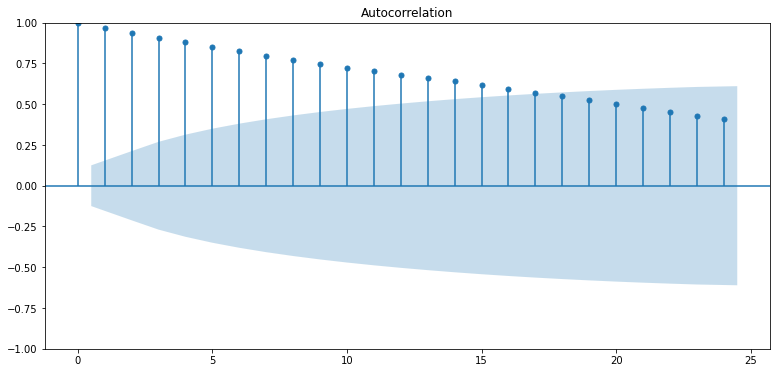

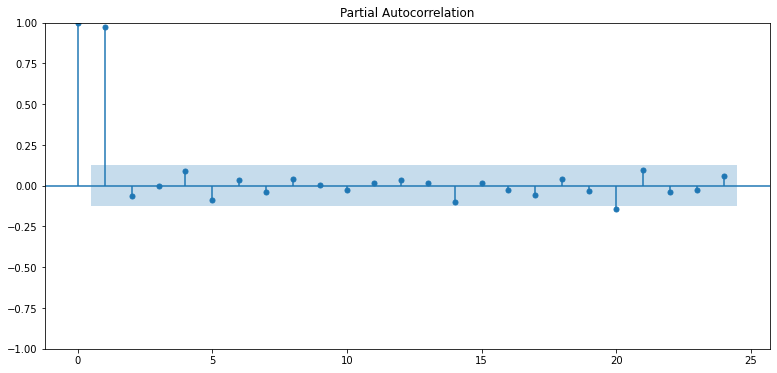

In [13]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [21]:
#acf가 점점 떨어지는 모양세이기 때문에 p값을 사용하는 것이 적합 # p 17
#pacf는 상관도가 0이라 아무상관없는 데이터이기 때문에 고려 X

Results of Dickey-Fuller Test:
Test Statistic                -1.483912e+01
p-value                        1.848738e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


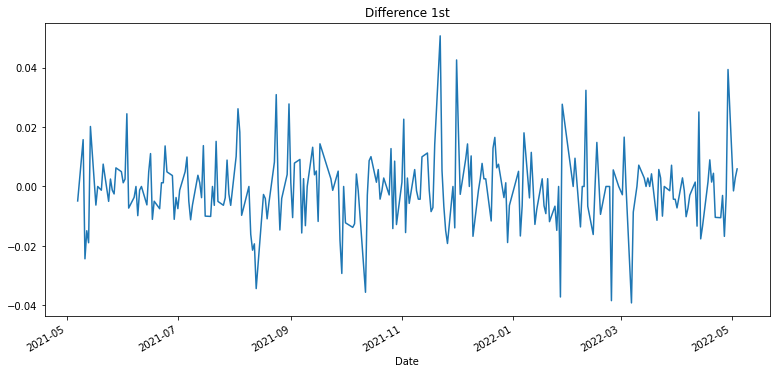

In [15]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)


#혹시 필요한 경우 3차 차분 구하기
#diff_3 = diff_2.diff(periods=1).iloc[1:]
#diff_3.plot(title='Difference 3rd')
#augmented_dickey_fuller_test(diff_3)

### STEP 6: ARIMA 모델 훈련과 테스트  
*ARIMA 모델 빌드와 훈련  
*모델 테스트 및 플로팅  
*최종 예측 모델 정확도 측정(MAPE)  



In [16]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

In [17]:

from statsmodels.tsa.arima.model import ARIMA
# Build and Train  Model

model = ARIMA(train_data, order=(1,1,0))#p, d, q
fit_model = model.fit()  #disp info print 여부. #코드오류때문에 사용하지 않음)
print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 653.512
Date:                Thu, 05 May 2022   AIC                          -1303.023
Time:                        07:09:11   BIC                          -1296.236
Sample:                             0   HQIC                         -1300.282
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0675      0.066      1.029      0.303      -0.061       0.196
sigma2         0.0002   1.01e-05     15.270      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

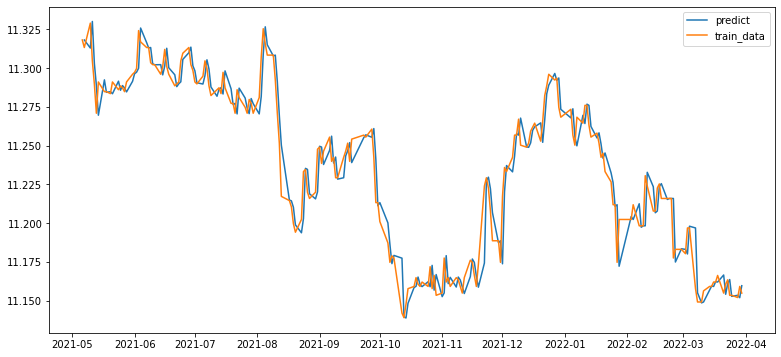

In [18]:
# 훈련 결과를 시각적으로 확인
fit_model=fit_model.predict()
fit_model = fit_model.drop(fit_model.index[0])
plt.plot(fit_model, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()


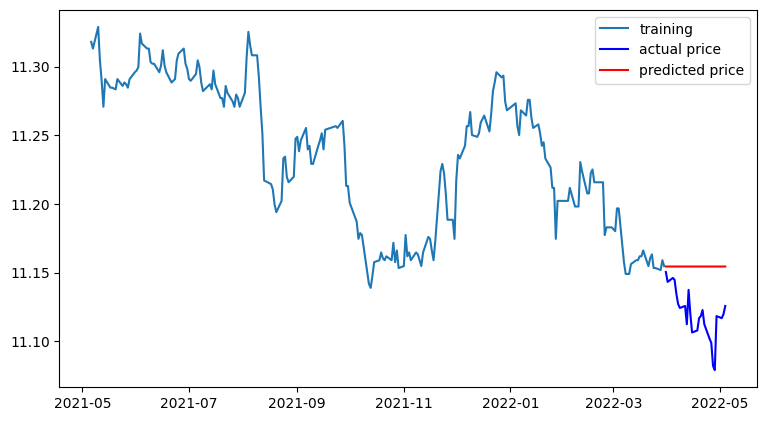

In [19]:

model = ARIMA(train_data, order=(1, 1, 0))
fit_model = model.fit() 
# Forecast : 결과가 fc에 담김.
fc = fit_model.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100)) #3.55%

MSE:  7046674.808350956
MAE:  2374.394573270934
RMSE:  2654.557365805259
MAPE: 3.55%


---

### 회고록.  
ARIMA를 사용하여 시계열 데이터를 준비하고 전처리를 수행한뒤 시계열 안정성을 분석하여 학습한 데이터셋을 이용해 적절한 ARIMA 모수를 찾아내 테스트하여 미래를 예측해보는 세번째 Explation이었다.  
기본 프로젝트인 삼성부터 시작해 apple, google, ms등의 주식까지 총 4개를 예측해보았다. 
운이좋게도 모든 프로젝트가 acf를 기준으로 arima 모수를 만들 수가 있었다. 
ARIMA 모델을 훈련시킬 때 p, q, d 수치가 중요하기에 이해하는 것에도 시간이 걸렸었다.
P-value와 Lags Used 수치가 적절하게 떨어질때까지 차분을 추가로 실행하거나 하이퍼 파라미터 값을 조정하는 둥의 과정을 거쳐 모든 주식이 MAPE수치가 15%이하로 나올 수 있었다.
초반 ARIMA개념을 이해하는데 많은 시간이 걸렸지만 한프로젝트의 함수 이해와 코드작성을 끝내니 나머지 분석은 작성한 코드를 기반으로 그래프 분석을 통해 하이퍼 파라미터 값만 변경해주면 되기에 추가 분석은 큰 어려움 없이 진행 할 수 있었다.

이번 시간은 통계지식이 필요했던 프로젝트였다. 통계와 관련된 스터디를 진행하는 것이 필요.

----

### Reference. (APA)
장용준. (2020). 손가락 하나 까딱하지 않는 주식 거래 시스템 구축. 위키북스.  # 별도움은 안됨  
Rob J Hyndman and George Athanasopoulos. (2018). Forecasting: Principles and Practice(2ed). Monash University. # 내용이 어려워 참고용으로만



-----